<a href="https://colab.research.google.com/github/mdrk300902/demo-repo/blob/main/CIFAR_10_Image_Classification_with_EfficientNet_B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 Image Classification with Enhanced EfficientNet-B0

## Problem Statement

Classifying images accurately into their respective categories is a fundamental challenge in computer vision. The CIFAR-10 dataset contains 60,000 32x32 color images divided into 10 classes. This project aims to develop a deep learning model that achieves high accuracy on CIFAR-10—including for difficult classes—while maintaining computational efficiency.

## Introduction

This project uses transfer learning to fine-tune EfficientNet-B0, a state-of-the-art convolutional neural network pretrained on ImageNet, for CIFAR-10 classification. Advanced data augmentation (random crop, horizontal flip, color jitter, random erasing), label smoothing, weight decay, and learning rate scheduling are employed to maximize generalization and performance. The approach emphasizes reproducibility, robust regularization, model checkpointing, full-model fine-tuning, and comprehensive evaluation including rich visualizations.

## Workflow

1. **Data Preparation:**  
   Load CIFAR-10 and apply advanced augmentations (random crop, flip, color jitter, random erasing). Normalize all images. Visualize sample images to validate augmentation.

2. **Model Initialization & Fine-tuning:**  
   Load EfficientNet-B0 pretrained on ImageNet; adapt its final layer for 10 classes. Unfreeze all layers for thorough fine-tuning.

3. **Training:**  
   Train the model for an extended number of epochs using Adam optimizer, label smoothing, and weight decay. Use a learning rate scheduler for optimal convergence and save checkpoints of the best performing model.

4. **Evaluation:**  
   Measure test accuracy and produce a detailed classification report after training. Visualize training loss, validation accuracy, and confusion matrix to assess performance and diagnose weaknesses.

5. **Visualization:**  
   Present augmented image examples, training curves, classification report, and confusion matrix to provide clear insights into model training and outcomes.



###Import Necessary Libraries


In [53]:
import torch
import timm
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

### 1. Define Transformations

In [58]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),                 # Convert PIL Image to tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize tensor
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.25)),  # Apply only to tensor!
])


### 2. Load CIFAR-10 Dataset


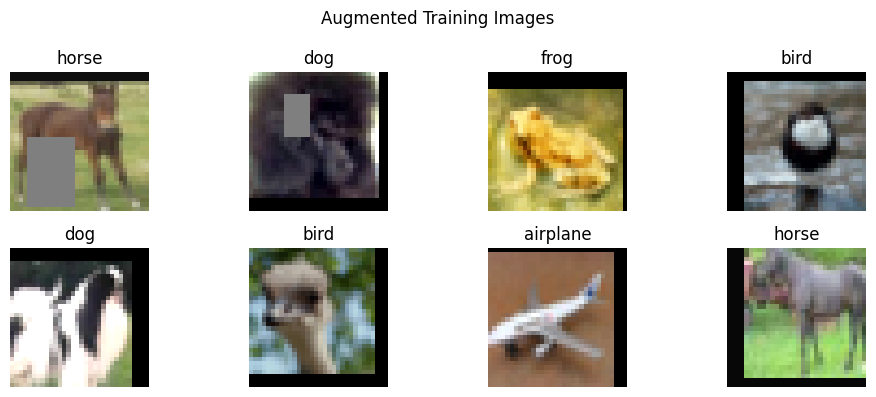

In [60]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

# 2a. Visualize Sample Training Images
classes = trainset.classes
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

images, labels = next(iter(trainloader))
plt.figure(figsize=(10, 4))
for i in range(8):
    plt.subplot(2, 4, i+1)
    imshow(images[i], classes[labels[i]])
plt.suptitle("Augmented Training Images")
plt.tight_layout()
plt.show()

### 3. Initialize Model

In [61]:
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=10)
for param in model.parameters():
    param.requires_grad = True  # Unfreeze all layers

### 4. Set Device

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

### 5. Define Loss and Optimizer

In [63]:
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)


### 6. Training Loop (with metric tracking)


In [65]:
NUM_EPOCHS = 10
train_losses, val_accuracies = [], []
best_acc = 0
best_model_wts = None

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0
    for imgs, labels in trainloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)

    # Evaluation on test set after each epoch (for validation)
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in testloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    epoch_acc = correct / total
    val_accuracies.append(epoch_acc)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train loss: {avg_loss:.4f}, Test Acc: {epoch_acc:.2%}")

    # Learning rate schedule
    scheduler.step(avg_loss)

    # Model checkpointing
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = model.state_dict().copy()

# Restore best model weights
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)

Epoch 1/10, Train loss: 1.4371, Test Acc: 68.32%
Epoch 2/10, Train loss: 1.2640, Test Acc: 73.80%
Epoch 3/10, Train loss: 1.1625, Test Acc: 77.03%
Epoch 4/10, Train loss: 1.0937, Test Acc: 79.52%
Epoch 5/10, Train loss: 1.0528, Test Acc: 81.06%
Epoch 6/10, Train loss: 1.0127, Test Acc: 81.65%
Epoch 7/10, Train loss: 0.9885, Test Acc: 83.75%
Epoch 8/10, Train loss: 0.9629, Test Acc: 82.64%
Epoch 9/10, Train loss: 0.9853, Test Acc: 82.73%
Epoch 10/10, Train loss: 0.9642, Test Acc: 83.30%


### 7. Evaluation & Accuracy tracking

In [66]:
model.eval()
correct, total = 0, 0
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in testloader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        all_preds.append(predicted.cpu())
        all_labels.append(labels.cpu())

test_accuracy = correct / total
print(f"\nBest Test accuracy: {test_accuracy:.2%}")


Best Test accuracy: 83.30%


### 8. Visualize Training Loss Curve

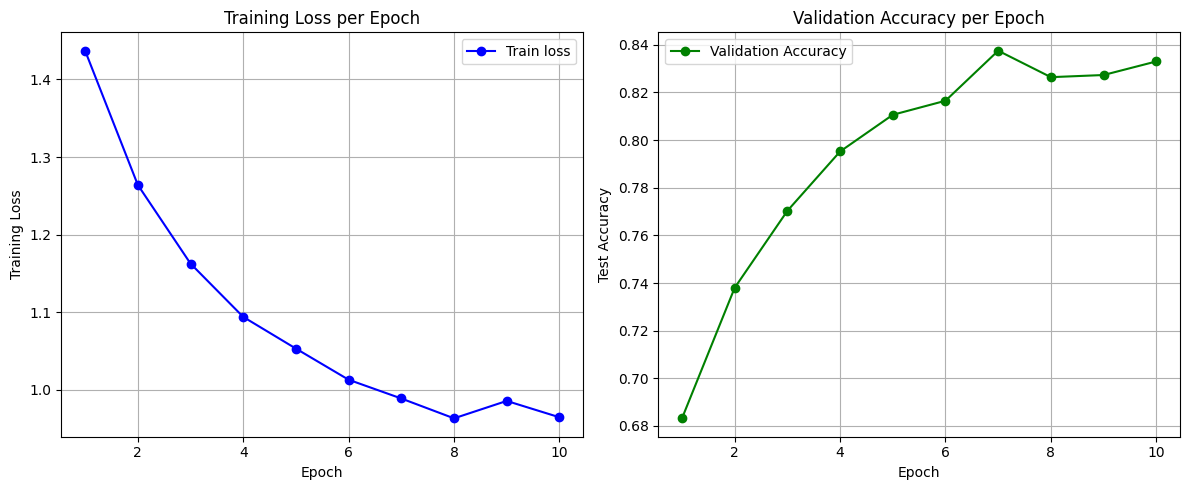

In [67]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, NUM_EPOCHS+1), train_losses, marker='o', color='b', label='Train loss')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch")
plt.legend(); plt.grid()

plt.subplot(1,2,2)
plt.plot(range(1, NUM_EPOCHS+1), val_accuracies, marker='o', color='g', label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.legend(); plt.grid()
plt.tight_layout()
plt.show()

# 9. Classification Report & Confusion Matrix


Classification Report:
              precision    recall  f1-score   support

    airplane       0.81      0.88      0.85      1000
  automobile       0.94      0.89      0.91      1000
        bird       0.85      0.73      0.79      1000
         cat       0.71      0.65      0.68      1000
        deer       0.81      0.82      0.82      1000
         dog       0.72      0.78      0.75      1000
        frog       0.84      0.91      0.87      1000
       horse       0.83      0.88      0.86      1000
        ship       0.92      0.88      0.90      1000
       truck       0.90      0.90      0.90      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



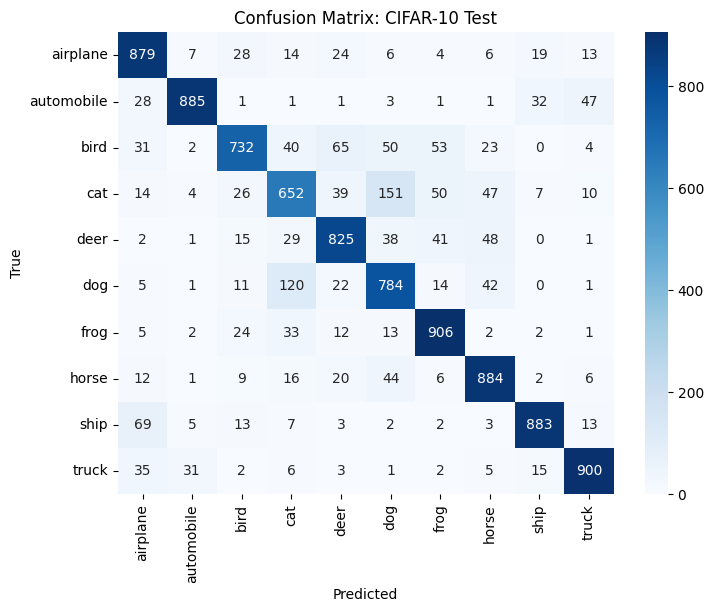

In [68]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true = torch.cat(all_labels).numpy()
y_pred = torch.cat(all_preds).numpy()
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: CIFAR-10 Test')
plt.show()